# Waiting List Model

## Christine Harvey

### Computational Social Science 600

Model to simulate the waiting list and multiple registrations in the organ transplant system.  Developed for the Course Project in CSS 600: Introduction to Computational Social Science.

Model was developed using the Mesa package for Agent-Based Modeling.

In [1]:
import numpy.random as npr
from random import shuffle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import Grid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner 

## Designing Patients

The agents in this model are patients.  Patients are either Waiting, Selected, Transplanted, or Deceased, this state of the patient corresponds to the patient's condition.

Patients also have other attributes including a unique identifier, an assigned lifespan, a counter for the amount of time they have been waiting, a list of regions where they are registered and a primary region of registration.

In [2]:
class Patient(Agent):
    '''
    A patient in the simulation.
    
    Attributes:
        condition: Waiting or Selected or Transplanted or Deceased
        regions: regions where the patient is waiting
        my_id: Integer identifier, represents order the agent is added to the model
        primary: Primary listing region of the agent
        lifespan: Lifespan of the agent before selection
        waiting: amount of time spent waiting on the list
        advantaged: whether or not the patient is advantaged
        
    '''
    def __init__(self, my_id, regions, lifespan, waiting=0):
        '''
        Create a new agent
        Args: 
        '''
        self.my_id = str(my_id)
        self.regions = regions
        self.primary = self.regions[0]
        self.condition = "Waiting"
        self.lifespan = lifespan
        self.waiting = waiting
        if len(regions) > 1:
            self.advantaged = True
        else:
            self.advantaged = False
        
    def selected(self):
        '''
        Set the patient's condition to "Selected"
        '''
        self.condition = "Selected"
        
    def get_advantaged(self):
        '''
        Check if patient is advantaged
        '''
        return self.advantaged
    def get_waiting(self):
        '''
        Get the patient's waiting years
        '''
        return self.waiting
        
    def get_primary(self):
        '''
        Return the patient's primary listing
        '''
        return self.primary
            
    def get_condition(self):
        '''
        Return the patient's condition
        '''
        return self.condition
        
    def step(self, model):
        '''
        If a patient is at the top of the list, they will receive a transplant
        Age the patient by one time step.
        If the patient has been selected, change their condition to transplanted
        Else: if the patient is waiting and waiting >= lifespan, change condition to Deceased
        '''
        # Increment the patient's waiting
        if self.condition == "Waiting":
            self.waiting += 1
        #print "Patient " + self.my_id +" aged to " + str(self.waiting)
        
        # Convert person to transplant
        if self.condition == "Selected":
            self.condition = "Transplanted" 
        elif self.condition == "Waiting" and self.waiting >= self.lifespan:
            self.condition = "Deceased"
            
        
    def __str__(self):
        return str(self.my_id)

## Defining the Model

The model, *Waiting List*, simulated the patients in the waiting list environment.  

### Model Inputs
The model as many parameters which can be set on the command line including:

* regions: Number of regions in the model
* initial_patients: Number of patients to use when the model is initiated
* additional_patients: number of patients to be added to the model yearly
* transplant_rates: list of transplant rates, this is the number of patients per list that will be selected for a transplant each year.
* queue_probabilities: probability that a generated patient will be assigned to each of the regions
* advantage_prob: Probability that a patient in the model will be "advantaged" and therefore able to register on more than one list.
* output: flag for the output of the model, set to true by default, can be turned off in batch mode.
* average_lifespan: average lifespan for a patient in the model, used to randomly generate patient's expected life-spans.
* smart_listing: flag for whether agents will pick alternate waiting lists based on shorter queues


### Model State
In order the track the current state of the model, several variables are used:

* ticks: time steps of the model that have passed, this can be viewed reasonably as months
* candidates: number of total candidated active in the model
* queue: List of lists of the waiting list queues in the model

The DataCollector feature of Mesa is used to teach the model objects and the number of patients in each state.  This data collector tracks the number of patients in each of the patient states (waiting, selected, deceased, or transplanted) at every time step and records the informaiton in an an easy to plot data frame.

### Model Outputs

In addition to the DataCollector of patient states, the model also tracks several important lists that track the number of agents in each of the queues meeting certain criteria:

* primary_listing_transplant: Patients transplanted that were a primary listing in this queue
* alternate_listing_transplant: Patients transplanted that were an alternate listing in this queue
* count_transplanted_elsewhere: Primary listed patients that receieved a transplant elsewhere
* count_deceased_before_transplant: Number of primary patients that died before receiving a transplant
* primary_waiting: Number of Primary Patients added to the Waiting List
* alternate_waiting: Number of Alternate Patients added to the Waiting List

### Methods
The model consists of several methods including add_candidates, step, print_queue, count_types, and a variety of statistical reporting methods.  

#### Add Candidates
The add_candidates method takes the number of people to be added as an input.  This number of candidates are created and added to the model.  

Creating a canditate consists of the following steps:

1. Each patient is first added to a primary region, which is randomly selected based on the queue_probabilities variable specified in the inalilization phase of the model.  
2. Once a patient is added to a primary region, it is stochastically determined if they will be listed at more than one queue based on the advantage_probability.  If the patient is selected as being advantaged, they are randomly added to a random number of additional queues, uniformly distributed between 1 and regions/2.  This means an advantage patient has the ability to have an additional registration at anywhere from 2 regions to half of all regions.  
3.  Assign the patient an ID based on the order they are generated.
4.  Assign the patient a lifespan according to max_lifespan.
5.  If this is the initial round of patients, assign the waiting time accoriding to the distribution of patients from the UNOS website (http://optn.transplant.hrsa.gov/).

|| All Time     | < 30 Days | 30 to < 90 Days | 90 Days to < 6 Months | 6 Months to < 1 Year | 1 Year to < 2 Years | 2 Years to < 3 Years | 3 Years to < 5 Years | 5 or More Years | 
|--------------|-----------|-----------------|-----------------------|----------------------|---------------------|----------------------|----------------------|-----------------|--------|
| Candidates   | 122,171   | 3,912           | 7,815                 | 9,897                | 17,037              | 27,153               | 20,471               | 23,217          | 18,405 |
| % Candidates | 100       | 3.2%            | 6.4%                  | 8.1%                 | 13.9%               | 22.2%                | 16.8%                | 19.0%           | 15.1%  |

5.  Create the patient using the Patient Class.
6.  Add the patient to their assigned waiting lists, appending the agents to the end of each of the lists.
7.  Add the new patient to the schedule.

#### Step
The step method moved the model one step forward.  Each time the step function is run it executed the following procedures and actions:

1.  Schedule the next step for the model to take.
2.  Collect the previously specified data. 
3.  Select the agents that will be transplanted.  First the order of the waiting list queues needs to be randomly shuffled.  This ensures that certain waiting lists won't always be transplanted before others.  This is especially important for multiple listings, once a patient is selected on one list they are skipped over for a transplant in another region.  Therefore whichever region selects patients first will be transplanting multiple wait-listed patients more frequently than any other list.
    a.  Loop over the regions in the shuffled order and determine the number to be selected from the rates previously provided in the initalization phase, nTransplant.
    b.  Copy the queue from the listing of queues to a local copy for simplicity.
    c.  Select the first nTransplant patients that are eligible (not already transplanted, selected, or deceased).  Change the state of these patients to "Selected".
4.  Add new patients to the list, according to the numbe of specified in the initalization phase as additional_patients.
5.  Increment the number of time steps elapsed by 1.
6.  If there are no longer any patients waiing or the time steps has exceeded 60, stop running the model.

#### Print Queue
Helper function to print out the queues of patients.  These are printed out in list of list formats with the patient identifier numbers.

#### Count Type
The count_type function is used to count the total number of patients of a given state at each time step of the model.
            
#### Get \* Functions

The following functions are all used to return summary statistics when the model is run in batch mode, these statistics are sums of the earlier mentioned outputs of the model.  

* get_primary_center_transplants: The number of primary transplants
* get_alternate_center_transplants: The number of alernate translplants
* get_transplanted_elsewhere: The total number of patients that were transplanted at a region that was *not* their primary location.
* get_deceased_before_transplant:  The number of patients that died before receieving a transplant, counted once for the primary listing.
* get_primary_listings: The number of primary transplant listings
* get_alternate_listings: The number of alternate transplant listings

#### Finalize
When the model is not run in batch mode, this method is useful to view the overall model statistics generated.  

In [3]:
class WaitingList(Model):
    '''
    Waiting List model describing multiple queues and registration listing in the organ
    transplant system.
    '''
    def __init__(self, regions, initial_patients, additional_patients, 
                 transplant_rates=[50, 31, 16, 21], queue_probabilities=[0.50, 0.20, 0.10, 0.20], 
                 advantage_prob=0.05, output=True, average_lifespan=98, smart_listing=True):
        '''
        Method to initialize the model
        
        arguments:
            regions: number of regions in the model
            intiial_patients: total number of patients to initiate in the model
            additional_patients: number of patients to be added to the model yearly
            transplant_rates: list of transplant rates, this is the number of patients per 
                list that will be selected for a transplant each year.
            queue_probabilities: probability that a generated patient will be assigned
                to each of the regions
            advantage_prob: Probability that a patient in the model will be "advantaged" and 
                therefore able to register on more than one list.
            output: flag for the output of the model, set to true by default, can be turned off in batch mode
            max_lifespan: maximum lifespan for a patient
            smart_listing: flag for whether agents will pick alternate waiting lists based on shorter queues
        '''
        print "Running model for: ", advantage_prob
        
        # Initalize model parameters
        self.regions = regions
        self.intial_patients = initial_patients
        self.rates = transplant_rates
        self.advantage_probability = advantage_prob
        self.additional_patients = additional_patients
        self.queue_probabilities = queue_probabilities
        self.output = output
        self.average_lifespan = average_lifespan
        self.smart_listing = smart_listing
        
        # Set up initial values for tracking model state
        self.ticks = 0
        self.candidates = 0
        
        # Set up the list of queues for the waiting lists
        self.queues = []
        
        # Set up small lists to track the outcomes of each of the waiting lists
        self.primary_listing_transplant = []  # TX of a patient that was a primary listing
        self.alternate_listing_transplant = []  # TX of a patient that was an alternate listing
        self.count_transplanted_elsewhere = []  # Primary patient was transplanted elsewhere
        self.count_deceased_before_transplant = []  # Primary patient died before transplantation
        self.primary_waiting = []  # Number of Primary Patients added to the Waiting List
        self.alternate_waiting = []  # Number of Alternate Patients added to the Waiting List
                
        # Set up model objects, to track the number of patients in each state.
        self.schedule = RandomActivation(self)
        self.dc = DataCollector({"Waiting": lambda m: self.count_type(m, "Waiting"), 
                                "Selected": lambda m: self.count_type(m, "Selected"),
                                "Deceased": lambda m: self.count_type(m, "Deceased"),
                                "Transplanted": lambda m: self.count_type(m, "Transplanted")})
        
        # Initalize all the regions
        for i in range(self.regions):
            self.queues.append([])
            self.primary_listing_transplant.append(0)
            self.alternate_listing_transplant.append(0)
            self.count_deceased_before_transplant.append(0)
            self.count_transplanted_elsewhere.append(0)
            self.primary_waiting.append(0)
            self.alternate_waiting.append(0)
            
        
        self.add_candidates(self.intial_patients, initial=True)
        
        self.running = True
        
    def add_candidates(self, num_to_add, initial=False):
        """
        Add people to the regions
        
        args:
        num_to_add: number of agent to add
        initial: Whether or not this is the initial round of patients
        """
        # Place a person in each region
        for i in range(num_to_add):
            # Pick the primary region
            patient_region = list(npr.choice(self.regions, 1, replace=False, p=self.queue_probabilities))
            self.primary_waiting[patient_region[0]] += 1
            # Determine if the patient is advantaged, random number > 99, add more regions
            if npr.rand() <= self.advantage_probability:
                # Remove the primary region from the list of possibilities
                possible_regions = range(self.regions)
                possible_regions.remove(patient_region[0])
                # if using self.smart-listing, remove the chosen primary region from the rankings
                if self.smart_listing:
                    queue_sizes = []
                    # Calculations of transplant rates/waiting list size calculations - for smart listing
                    for region in range(self.regions):
                        queue_sizes.append(len(self.queues[region]))
                    best_choice_score =  list(np.array(self.rates).astype('float')/(np.array(queue_sizes)+1))
                    best_choice_score.pop(patient_region[0])
                    probs = np.array(best_choice_score)/sum(best_choice_score)
                    
                    # Select 1 to regions/2 more regions to join the waiting list
                    secondary_listings = list(npr.choice(possible_regions, npr.randint(1, self.regions/2), replace=False, p=probs))
                else:
                    secondary_listings = list(npr.choice(possible_regions, npr.randint(1, self.regions/2), replace=False))
                
                patient_region.extend(secondary_listings)
                # Add patient counts to alternate_waiting structure
                for listing in secondary_listings:
                    self.alternate_waiting[listing] += 1
                
            patient_id = self.candidates
            self.candidates += 1
            
            # If this is the initial patient addition, provide the patient with waiting time.
            if initial:
                # Create probability tables from the distribution above
                options = [[0,1],[1,3],[3,6],[6,12],[12,24],[24,36],[36,60],[60,80]]
                initial_prob = [0.031, 0.061, 0.077, 0.133, 0.212, 0.160, 0.182, 0.144]
                # Choose the waiting range for the patient
                patient_waiting_range = npr.choice(len(options), 1, p=initial_prob)
                # Use the time range to select the waiting time
                patient_waiting = npr.randint(options[patient_waiting_range][0], options[patient_waiting_range][1])
                patient_lifespan = 5*npr.randn(1)[0] + self.average_lifespan
                
                # Ensure Patients don't have a shorter lifespan than the time they've already spend waiting
                while patient_waiting > patient_lifespan:
                    patient_lifespan = 5*npr.randn(1)[0] + self.average_lifespan
                    print patient_waiting, patient_lifespan
                
            else:
                patient_waiting = 0
                # Set the patient's lifespan using a normal random number distribution N(average_lifespan, 25)
                patient_lifespan = 5*npr.randn(1)[0] + self.average_lifespan
            
            # Create the patient
            new_patient = Patient(patient_id, patient_region, patient_lifespan, patient_waiting)
            
            # Add to the queue
            for q in patient_region:
                self.queues[q].append(new_patient)
            
            # Add the the schedule
            self.schedule.add(new_patient)
            
                
    def step(self):
        '''
        Advance the model by one step.
        '''
        self.schedule.step()
        self.dc.collect(self)
        
        """
        Select agents for transplant
        """        
        # Shuffle the order
        region_list = range(self.regions)
        shuffle(region_list)
        
        # Loop over the regions
        for i in region_list:
            # transplants to be performed
            num_to_select = self.rates[i]
            queue = self.queues[i]
            
            # Mark patient as selected
            j = 0
            while j < num_to_select and len(queue) > 0:
                top_of_list = queue.pop(0)
                # print top_of_list.get_condition()
                if top_of_list.get_condition() == "Selected" or top_of_list.get_condition() == "Transplanted":
                    # If the patient has already been selected or transplanted, another location reached first
                    # Only count if primary
                    if top_of_list.get_primary() == i:
                        self.count_transplanted_elsewhere[i] +=1
                    
                elif top_of_list.get_condition() == "Deceased":
                    # Patient died while waiting only count if primary
                    if top_of_list.get_primary() == i:
                        self.count_deceased_before_transplant[i] +=1
                    
                else:
                    top_of_list.selected()
                    # If this is the primary listing location, add to the number of primary transplants given
                    if top_of_list.get_primary() == i:
                        self.primary_listing_transplant[i] += 1
                    else:
                        self.alternate_listing_transplant[i] += 1
                    j+=1
        
        # Add new patients
        self.add_candidates(self.additional_patients)
        
        self.ticks += 1
                
        # Halt if no more waiting or TS >= 120
        if self.count_type(self, "Waiting") == 0 or self.ticks > 120:
            if self.output:
                self.finalize()
            self.running = False
            
    def print_queue(self):
        # Print out the intitial Queues
        for queue in self.queues:
            q = []
            for candidate in queue:
                q.append(str(candidate))
            print q
    
    @staticmethod
    def count_type(model, patient_condition):
        '''
        Helper method to count trees in a given condition in a given model.
        '''
        count = 0
        for patient in model.schedule.agents:
            if patient.condition == patient_condition:
                count += 1
        return count
    
    def get_primary_center_transplants(model):
        return sum(model.primary_listing_transplant)
    def get_alternate_center_transplants(model):
        return sum(model.alternate_listing_transplant)
    def get_transplanted_elsewhere(model):
        return sum(model.count_transplanted_elsewhere)
    def get_deceased_before_transplant(model):
        return sum(model.count_deceased_before_transplant)
    def get_primary_listings(model):
        return sum(model.primary_waiting)
    def get_alternate_listings(model):
        return sum(model.alternate_waiting)
    def get_waiting(model):
        count = 0
        for patient in model.schedule.agents:
            if patient.get_condition() == "Waiting":
                count += 1
        return count
    def get_transplants(model):
        count = 0
        for patient in model.schedule.agents:
            if patient.get_condition() == "Transplanted":
                count += 1
        return count
    def get_advantaged_transplants(model):
        count = 0
        for patient in model.schedule.agents:
            if patient.get_condition() == "Transplanted":
                if patient.get_advantaged():
                    count += 1
        return count/float(model.get_transplants())
    def get_deceased(model):
        count = 0
        for patient in model.schedule.agents:
            if patient.get_condition() == "Deceased":
                count += 1
        return count
    def get_average_waiting(model):
        count = 0
        waiting_time = 0
        for patient in model.schedule.agents:
            if patient.get_condition() == "Transplanted":
                count += 1
                waiting_time += patient.get_waiting()
        return waiting_time / float(count)
    def get_primary_waiting_rates(model):
        count = [0, 0, 0, 0]
        wrates = [0, 0, 0, 0]
        for patient in model.schedule.agents:
            if patient.get_condition() == "Transplanted":
                p = patient.get_primary()
                count[p] += 1
                wrates[p] += patient.get_waiting()
        return np.array(wrates) / np.array(count).astype('float')
    def get_primary_death_rates(model):
        return np.array(model.count_deceased_before_transplant) / np.array(model.primary_waiting).astype('float')
    
    def finalize(model):
        print "Number of primary Center Transplants: \t" + str(model.primary_listing_transplant)
        print "Number of alternate Center Transplants: \t" + str(model.alternate_listing_transplant)
        print "Number Transplanted elsewhere: \t" + str(model.count_transplanted_elsewhere)
        print "Number of deceased before transplant: \t" + str(model.count_deceased_before_transplant)  
        print "Number Primary Listings: \t" + str(model.primary_waiting)
        print "Number Alternate Listings: \t" + str(model.alternate_waiting)
        print "Percent of transplants that were advantaged: " + str(model.get_advantaged_transplants())
        print "Average Wait Time: " + str(model.get_average_waiting())+"\n"
        print "Average Wait Times" + str(model.get_primary_waiting_rates())
        print "Average Deaths" + str(model.get_primary_death_rates())
        print "\n"

## Running the model

Set up an example run with:

* regions = 4: Choose about four regions to represent
* initial_patients = 16000: Size of the kidney waiting list
* additional_patients = 2300: Transplant additions (Subtracting the number removals for the followin reasons: of living donors, Transplanted in another country, Unable to contact candidate, Waiting for KP, will not Accept Isol. Or	Also Waiting for KP; recvd KP, Also Waiting for KP; recvd Pancreas Alon, Refused transplant, Other, Condition Improved, and Transplanted Elsewhere)
* transplant_rates = [610, 370, 188, 255]
    * use data from CAOP-OP1 OneLegacy DSA (610 DD TX)
    * use data from ILP-OP1 Gifr of hope DSA (370 DD TX)
    * use data from INOP-OP1 Indiana Donor Network DSA (188 DD TX)
    * use data from MNOP-OP1 Lifesource Upper Midwest OPO (255 DD TX)
* queue_probabilities = [0.50, 0.20, 0.10, 0.20]
    * use data from CAOP-OP1 OneLegacy DSA (1396 additions)
    * use data from ILP-OP1 Gifr of hope DSA (568 additions)
    * use data from INOP-OP1 Indiana Donor Network DSA (273 additions)
    * use data from MNOP-OP1 Lifesource Upper Midwest OPO (1057 additions)
* advantage_prob = 0.05
* output = True
* average_lifespan = 98

Data from UNOS Website, cited in paper.

In [4]:
# Remember to divide above yearly numbers by 12
w = WaitingList(4, 16000, 230, transplant_rates=[50, 31, 16, 21], queue_probabilities=[0.50, 0.20, 0.10, 0.20], 
                 advantage_prob=0.05, output=True, average_lifespan=98)
w.run_model()

Running model for:  0.05
Number of primary Center Transplants: 	[6042, 3492, 1697, 2476]
Number of alternate Center Transplants: 	[8, 259, 239, 65]
Number Transplanted elsewhere: 	[362, 31, 24, 135]
Number of deceased before transplant: 	[4225, 901, 476, 1592]
Number Primary Listings: 	[21869, 8939, 4316, 8706]
Number Alternate Listings: 	[308, 660, 730, 469]
Percent of transplants that were advantaged: 0.0596751412429
Average Wait Time: 71.6485875706

Average Wait Times[ 72.44669811  70.40017162  70.48887588  72.13751926]
Average Deaths[ 0.19319585  0.10079427  0.1102873   0.18286239]




## Add graphics
Plot the number of agents in each state over time.

In [5]:
results = w.dc.get_model_vars_dataframe()
results.tail()

,Deceased,Selected,Transplanted,Waiting
116,7131,0,13688,21861
117,7232,0,13806,21872
118,7328,0,13924,21888
119,7422,0,14042,21906
120,7535,0,14160,21905


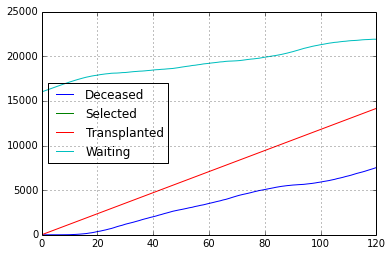

In [6]:
results.plot()

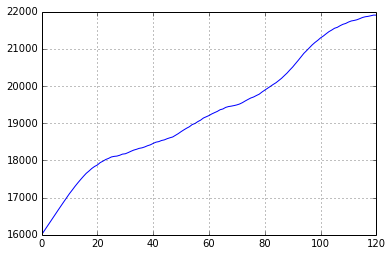

In [7]:
results.Waiting.plot()

## Batch runs

Use batch runs to explore the model.

Set up the parameter to cycle through in the model with the same statistics as above:

In [11]:
param_set = dict(regions=4,
                 initial_patients=16000,
                 additional_patients=230,
                 output=False,
                 average_lifespan=98,
                 # Vary advantage_prob from 0 to 1, in 0.01 increments:
                 advantage_prob=np.linspace(0,1,11)[1:]) 

Define the reporters that will be used in the model to track the outcomes of each scenario.

In [9]:
# At the end of each model run, calculate the fraction of trees which are Burned Out
model_reporter = {"Primary_Transplants": WaitingList.get_primary_center_transplants, 
                 "Alternate_Transplants": WaitingList.get_alternate_center_transplants,
                 "Transplanted_Elsewhere": WaitingList.get_transplanted_elsewhere,
                 "Deceased": WaitingList.get_deceased_before_transplant,
                 "Primary_Listings": WaitingList.get_primary_listings,
                 "Alternate_Listings": WaitingList.get_alternate_listings, 
                 "Count_Waiting": WaitingList.get_waiting, 
                 "Count_Deceased": WaitingList.get_deceased, 
                 "Percent_Advantaged": WaitingList.get_advantaged_transplants, 
                 "Average_Wait": WaitingList.get_average_waiting, 
                 "Death_Rates": WaitingList.get_primary_death_rates, 
                 "Wait_Rates": WaitingList.get_primary_waiting_rates}

In [10]:
# Create the batch runner
param_run = BatchRunner(WaitingList, param_set, model_reporters=model_reporter)

### Execute the batch runs
Perform the executions defined.  

In [12]:
param_run.run_all()

Running model for:  0.1
Running model for:  0.2
Running model for:  0.3
Running model for:  0.4
Running model for:  0.5
Running model for:  0.6
Running model for:  0.7
Running model for:  0.8
Running model for:  0.9
Running model for:  1.0


Collect information from the runs using the dataframe generated by the batch runs.

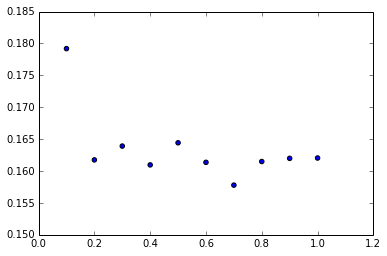

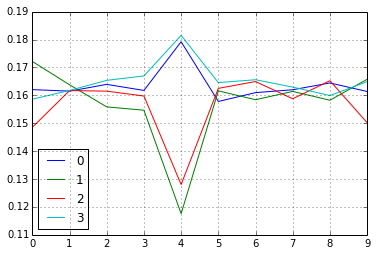

In [13]:
df = param_run.get_model_vars_dataframe()
DR = pd.DataFrame(list(df.Death_Rates))
plt.scatter(df.advantage_prob, DR[0])
DR.plot()

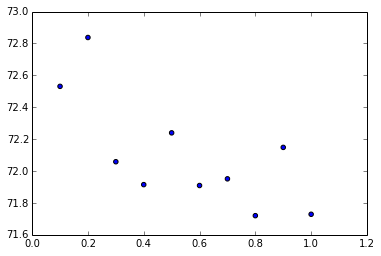

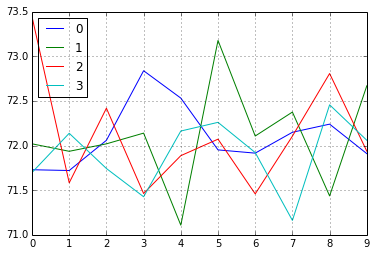

In [14]:
W = pd.DataFrame(list(df.Wait_Rates))
plt.scatter(df.advantage_prob, W[0])
W.plot()

#### Advantage Probability vs. Deceased

(0, 1)

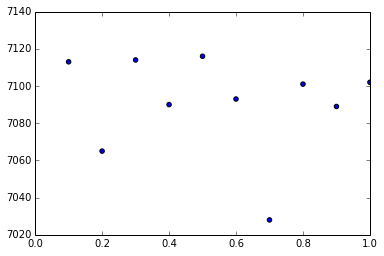

In [15]:
plt.scatter(df.advantage_prob, df.Deceased)
plt.xlim(0,1)

#### Number of Primary Waiting List Transplants performed

In [16]:
#plt.scatter(df.advantage_prob, df.Primary_Transplants)
#plt.xlim(0,1)

#### Number of Alternate Listing Transplant Performed

In [17]:
#plt.scatter(df.advantage_prob, df.Alternate_Transplants)
#plt.xlim(0,1)

#### Number of Primary and Alternate Waiting List Transplants performed

(0, 1)

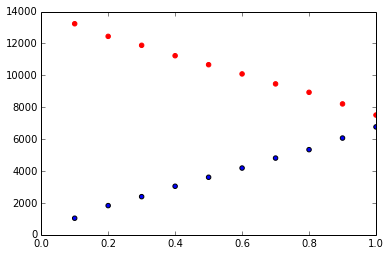

In [18]:
plt.scatter(df.advantage_prob, df.Primary_Transplants, color='red')
plt.scatter(df.advantage_prob, df.Alternate_Transplants)
plt.xlim(0,1)

#### Advantage Probability vs. Waiting List

(0, 1)

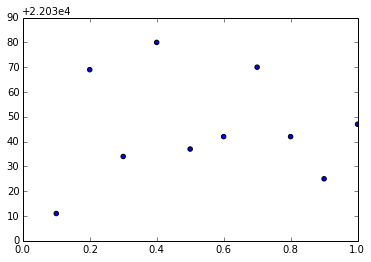

In [19]:
plt.scatter(df.advantage_prob, df.Count_Waiting)
plt.xlim(0,1)

#### Count of deceased

(0, 1)

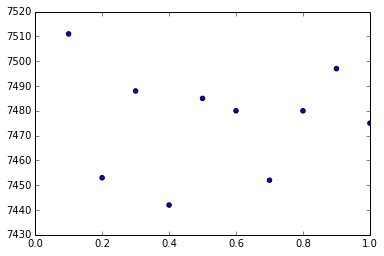

In [20]:
plt.scatter(df.advantage_prob, df.Count_Deceased)
plt.xlim(0,1)

#### Advantaged Percent

(0, 1)

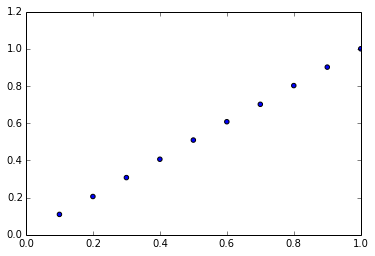

In [21]:
plt.scatter(df.advantage_prob, df.Percent_Advantaged)
plt.xlim(0,1)

(0, 1)

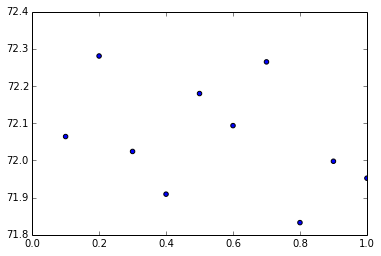

In [22]:
## Waiting time
plt.scatter(df.advantage_prob, df.Average_Wait)
plt.xlim(0,1)

### Execute a Larger batch run

In [23]:
param_set = dict(regions=4,
                 initial_patients=16000,
                 additional_patients=230,
                 output=False,
                 average_lifespan=98,
                 # Vary advantage_prob from 0 to 1, in 0.01 increments:
                 advantage_prob=np.linspace(0,1,101)[1:]) 

In [24]:
# Create the batch runner
param_run = BatchRunner(WaitingList, param_set, model_reporters=model_reporter)
param_run.run_all()

Running model for:  0.01
Running model for:  0.02
Running model for:  0.03
Running model for:  0.04
Running model for:  0.05
Running model for:  0.06
Running model for:  0.07
Running model for:  0.08
Running model for:  0.09
Running model for:  0.1
Running model for:  0.11
Running model for:  0.12
Running model for:  0.13
Running model for:  0.14
Running model for:  0.15
Running model for:  0.16
Running model for:  0.17
Running model for:  0.18
Running model for:  0.19
Running model for:  0.2
Running model for:  0.21
Running model for:  0.22
Running model for:  0.23
Running model for:  0.24
Running model for:  0.25
Running model for:  0.26
Running model for:  0.27
Running model for:  0.28
Running model for:  0.29
Running model for:  0.3
Running model for:  0.31
Running model for:  0.32
Running model for:  0.33
Running model for:  0.34
Running model for:  0.35
Running model for:  0.36
Running model for:  0.37
Running model for:  0.38
Running model for:  0.39
Running model for:  0.4
Runn

In [25]:
df = param_run.get_model_vars_dataframe()
df.head()

,Alternate_Listings,Alternate_Transplants,Average_Wait,Count_Deceased,Count_Waiting,Death_Rates,Deceased,Percent_Advantaged,Primary_Listings,Primary_Transplants,Run,Transplanted_Elsewhere,Wait_Rates,additional_patients,advantage_prob,average_lifespan,initial_patients,output,regions
0,6523,1406,72.037288,7518,22034,"[0.170088917408, 0.145333031264, 0.14557255447...",7142,0.156144,43830,12872,14,1396,"[72.3633435807, 71.3781078463, 72.3645761544, ...",230,0.15,98,16000,False,4
1,14406,2512,72.112712,7497,22055,"[0.161593903503, 0.160887656033, 0.15384615384...",7086,0.323941,43830,11766,32,2509,"[72.330831327, 71.5885490754, 72.6554385965, 7...",230,0.33,98,16000,False,4
2,32080,5005,72.058686,7481,22071,"[0.161492387179, 0.159867443721, 0.16146297948...",7114,0.731568,43830,9273,72,4983,"[71.8386004515, 71.8682805269, 72.6340956341, ...",230,0.73,98,16000,False,4
3,37255,5791,72.084816,7464,22088,"[0.163979229298, 0.168066273264, 0.15418400369...",7106,0.847105,43830,8487,84,5771,"[71.910386678, 72.4553345389, 72.4384615385, 7...",230,0.85,98,16000,False,4
4,33464,5076,71.886088,7464,22088,"[0.163703839458, 0.15886249429, 0.154159132007...",7110,0.767514,43830,9202,75,5057,"[71.6546711826, 71.6173758865, 72.1812585499, ...",230,0.76,98,16000,False,4


In [27]:
sorted_df = df.sort('advantage_prob')
print sorted_df

    Alternate_Listings  Alternate_Transplants  Average_Wait  Count_Deceased  \
6                  431                    130     71.381144            7671   
31                 881                    257     71.347881            7642   
14                1324                    323     71.343291            7611   
82                1714                    450     71.691949            7591   
35                2205                    592     71.666384            7520   
87                2715                    683     71.859181            7536   
8                 3044                    731     71.886864            7529   
79                3481                    828     71.998729            7467   
83                3927                    965     71.996540            7510   
61                4528                   1086     71.844633            7498   
21                4869                   1096     71.982133            7491   
37                5154                   1180     72

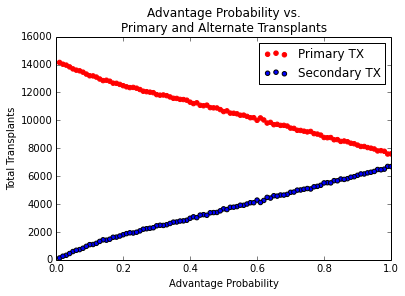

In [35]:
primary_tx = plt.scatter(df.advantage_prob, df.Primary_Transplants, color='red')
alternate_tx = plt.scatter(df.advantage_prob, df.Alternate_Transplants)
plt.xlim(0,1)
plt.ylim(0,16000)
plt.xlabel('Advantage Probability')
plt.ylabel('Total Transplants')
plt.legend([primary_tx, alternate_tx],["Primary TX", "Secondary TX"] )
plt.title('Advantage Probability vs. \nPrimary and Alternate Transplants')

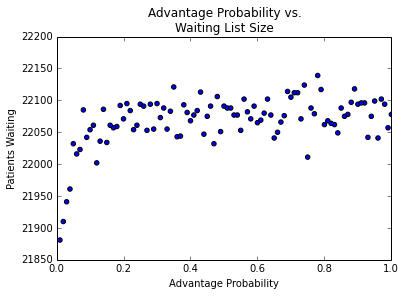

In [38]:
plt.scatter(df.advantage_prob, df.Count_Waiting)
plt.xlim(0,1)
plt.xlabel('Advantage Probability')
plt.ylabel('Patients Waiting')
plt.title('Advantage Probability vs. \nWaiting List Size')
#plt.ylim(0,25000)

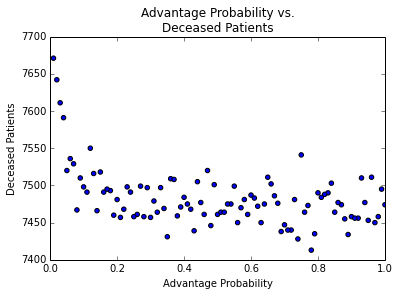

In [30]:
plt.scatter(df.advantage_prob, df.Count_Deceased)
plt.xlim(0,1)
plt.xlabel('Advantage Probability')
plt.ylabel('Deceased Patients')
plt.title('Advantage Probability vs. \nDeceased Patients')

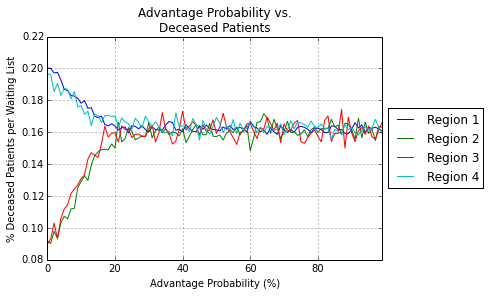

In [39]:
DR = pd.DataFrame(list(sorted_df.Death_Rates))
#plt.scatter(df.advantage_prob, DR[0],color='red')
#plt.scatter(df.advantage_prob, DR[1], color='blue')
#plt.scatter(df.advantage_prob, DR[2],color='green')
#plt.scatter(df.advantage_prob, DR[3], color='black')
#plt.xlim(0,1)

DR.plot()
plt.xlabel('Advantage Probability (%)')
plt.ylabel('% Deceased Patients per Waiting List')
plt.title('Advantage Probability vs. \nDeceased Patients')
plt.legend(['Region 1','Region 2','Region 3','Region 4'], loc='center left', bbox_to_anchor=(1, 0.5))

(0, 1)

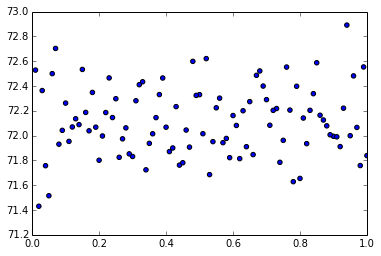

In [44]:
W = pd.DataFrame(list(sorted_df.Wait_Rates))
plt.scatter(df.advantage_prob, W[0])
plt.xlim(0,1)

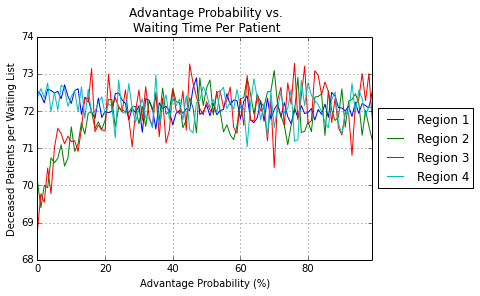

In [45]:
W.plot()
plt.xlabel('Advantage Probability (%)')
plt.ylabel('Deceased Patients per Waiting List')
plt.title('Advantage Probability vs. \n Waiting Time Per Patient')
plt.legend(['Region 1','Region 2','Region 3','Region 4'], loc='center left', bbox_to_anchor=(1, 0.5))

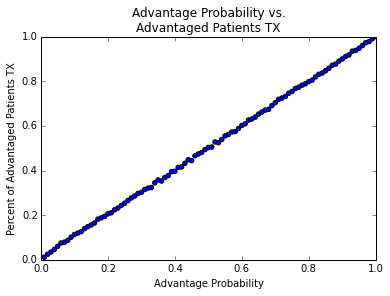

In [46]:
plt.scatter(df.advantage_prob, df.Percent_Advantaged)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Advantage Probability')
plt.ylabel('Percent of Advantaged Patients TX')
plt.title('Advantage Probability vs. \nAdvantaged Patients TX')